##SUPER RESOLUTION USING GANS

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import cv2
import os
import zipfile
from tensorflow.keras import mixed_precision

##EXTRACTING AND CREATING HIGH AND LOW RESOLUTION DATA

In [3]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Nagasaki_summer_internship/SR.zip")
zip_ref.extractall()
zip_ref.close()

In [4]:
for dirnames,dirpath,filenames in os.walk("dataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 7 directories and 0 images in '['Raw Data', 'train', 'val']'.
There are 16 directories and 0 images in '['high_res', 'low_res']'.
There are 25 directories and 855 images in '[]'.
There are 24 directories and 855 images in '[]'.
There are 13 directories and 0 images in '['high_res', 'low_res']'.
There are 22 directories and 685 images in '[]'.
There are 21 directories and 685 images in '[]'.
There are 11 directories and 0 images in '['high_res', 'low_res']'.
There are 20 directories and 170 images in '[]'.
There are 19 directories and 170 images in '[]'.


(-0.5, 255.5, 255.5, -0.5)

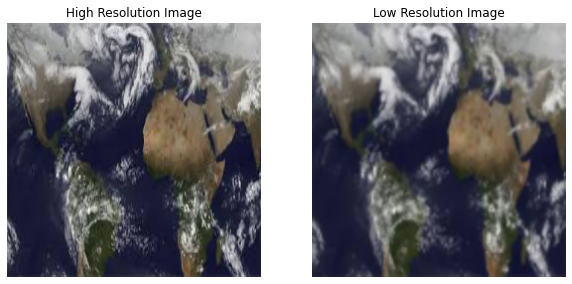

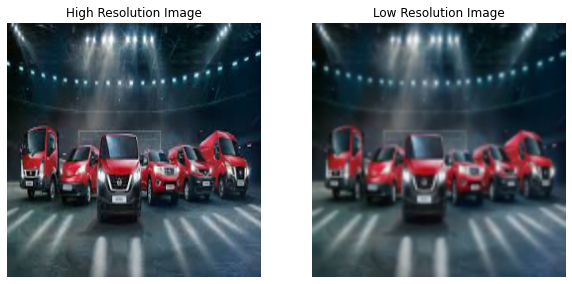

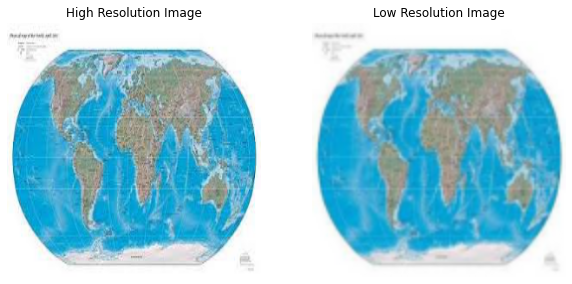

In [5]:
import matplotlib.image as mping
img_1 = mping.imread("/content/dataset/train/high_res/1.png")
img_2 = mping.imread("/content/dataset/train/low_res/1.png")
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img_1)
plt.title("High Resolution Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_2)
plt.title("Low Resolution Image")
plt.axis("off")
img_3 = mping.imread("/content/dataset/train/high_res/20.png")
img_4 = mping.imread("/content/dataset/train/low_res/20.png")
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img_3)
plt.title("High Resolution Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_4)
plt.title("Low Resolution Image")
plt.axis("off")
img_5 = mping.imread("/content/dataset/train/high_res/100.png")
img_6 = mping.imread("/content/dataset/train/low_res/100.png")
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img_5)
plt.title("High Resolution Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_6)
plt.title("Low Resolution Image")
plt.axis("off")

In [6]:
from keras.preprocessing.image import img_to_array
import re
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
h_SIZE = 128
high_img = []
path = '/content/dataset/Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (h_SIZE, h_SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))


low_img = []
l_SIZE=32
path = '/content/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
     if i == '855.jpg':
        break
     else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (l_SIZE, l_SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|██████████| 855/855 [00:01<00:00, 448.03it/s]


In [7]:
train_high_res = high_img[:700]
train_low_res = low_img[:700]
train_high_res = np.reshape(train_high_res,(len(train_high_res),h_SIZE,h_SIZE,3))
train_low_res = np.reshape(train_low_res,(len(train_low_res),l_SIZE,l_SIZE,3))

test_high_res = high_img[700:]
test_low_res = low_img[700:]
test_high_res= np.reshape(test_high_res,(len(test_high_res),h_SIZE,h_SIZE,3))
test_low_res = np.reshape(test_low_res,(len(test_low_res),l_SIZE,l_SIZE,3))

print("Shape of training images:",train_high_res.shape)
print("Shape of test images:",test_high_res.shape)
print("Shape of training images:",train_low_res.shape)
print("Shape of test images:",test_low_res.shape)

Shape of training images: (700, 128, 128, 3)
Shape of test images: (155, 128, 128, 3)
Shape of training images: (700, 32, 32, 3)
Shape of test images: (155, 32, 32, 3)


SRGAN 

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [9]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [10]:
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [11]:
from keras.applications.vgg19 import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


In [12]:
hr_shape = (test_high_res.shape[1], test_high_res.shape[2], test_high_res.shape[3])
lr_shape = (test_low_res.shape[1], test_low_res.shape[2], test_low_res.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [13]:
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

In [14]:
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(train_high_res.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(train_high_res[start_idx:end_idx])
    train_lr_batches.append(train_low_res[start_idx:end_idx])
    
    
epochs = 100

In [33]:
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 5 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("/content/drive/MyDrive/Colab Notebooks/Nagasaki_summer_internship/models"+ str(e+1) +".h5")

100%|██████████| 700/700 [01:54<00:00,  6.10it/s]


epoch: 1 g_loss: 82.2048161820003 d_loss: [2.58778428 0.74285714]


100%|██████████| 700/700 [01:45<00:00,  6.61it/s]


epoch: 2 g_loss: 56.75034205300467 d_loss: [0.82275111 0.84      ]


100%|██████████| 700/700 [01:47<00:00,  6.52it/s]


epoch: 3 g_loss: 52.55920995916639 d_loss: [0.83841266 0.84071429]


100%|██████████| 700/700 [01:46<00:00,  6.58it/s]


epoch: 4 g_loss: 48.76814739363534 d_loss: [0.66825469 0.89714286]


100%|██████████| 700/700 [01:47<00:00,  6.53it/s]

epoch: 5 g_loss: 41.783774540424346 d_loss: [0.60201976 0.92642857]



100%|██████████| 700/700 [01:46<00:00,  6.58it/s]


epoch: 6 g_loss: 39.87505978652409 d_loss: [0.63927416 0.93      ]


100%|██████████| 700/700 [01:47<00:00,  6.50it/s]


epoch: 7 g_loss: 270.9908651372365 d_loss: [0.30649568 0.96428571]


100%|██████████| 700/700 [01:47<00:00,  6.50it/s]


epoch: 8 g_loss: 56.42742575577327 d_loss: [0.44636999 0.96857143]


100%|██████████| 700/700 [01:45<00:00,  6.63it/s]


epoch: 9 g_loss: 53.07824923787798 d_loss: [0.55891455 0.95642857]


100%|██████████| 700/700 [01:48<00:00,  6.48it/s]

epoch: 10 g_loss: 49.23648048605238 d_loss: [0.11465641 0.98142857]



100%|██████████| 700/700 [01:46<00:00,  6.57it/s]


epoch: 11 g_loss: 44.290696076325005 d_loss: [0.45365875 0.95928571]


100%|██████████| 700/700 [01:47<00:00,  6.52it/s]


epoch: 12 g_loss: 45.58564497607095 d_loss: [0.17867996 0.98      ]


100%|██████████| 700/700 [01:46<00:00,  6.59it/s]


epoch: 13 g_loss: 43.08646382297788 d_loss: [0.23905569 0.96714286]


100%|██████████| 700/700 [01:47<00:00,  6.53it/s]


epoch: 14 g_loss: 41.304702104159766 d_loss: [0.22489509 0.97714286]


100%|██████████| 700/700 [01:46<00:00,  6.55it/s]

epoch: 15 g_loss: 39.82360791853496 d_loss: [0.14305423 0.98      ]



100%|██████████| 700/700 [01:46<00:00,  6.55it/s]


epoch: 16 g_loss: 38.41017634204456 d_loss: [0.16461816 0.97928571]


100%|██████████| 700/700 [01:46<00:00,  6.55it/s]


epoch: 17 g_loss: 37.46978115081787 d_loss: [0.13917888 0.97928571]


100%|██████████| 700/700 [01:46<00:00,  6.57it/s]


epoch: 18 g_loss: 37.5216561455386 d_loss: [0.093528   0.98357143]


100%|██████████| 700/700 [01:46<00:00,  6.60it/s]


epoch: 19 g_loss: 36.67809797133718 d_loss: [0.07449608 0.99214286]


100%|██████████| 700/700 [01:44<00:00,  6.72it/s]

epoch: 20 g_loss: 43.83260624647141 d_loss: [0.21569229 0.98142857]



100%|██████████| 700/700 [01:44<00:00,  6.70it/s]


epoch: 21 g_loss: 40.5394343328476 d_loss: [0.09380877 0.98571429]


100%|██████████| 700/700 [01:44<00:00,  6.70it/s]


epoch: 22 g_loss: 35.456118657418656 d_loss: [0.03463393 0.99428571]


100%|██████████| 700/700 [01:43<00:00,  6.76it/s]


epoch: 23 g_loss: 34.247356019871575 d_loss: [0.04784655 0.995     ]


100%|██████████| 700/700 [01:44<00:00,  6.73it/s]


epoch: 24 g_loss: 33.68099087715149 d_loss: [0.12827344 0.99214286]


100%|██████████| 700/700 [01:43<00:00,  6.77it/s]

epoch: 25 g_loss: 33.299649740968434 d_loss: [5.40602921e-06 1.00000000e+00]



100%|██████████| 700/700 [01:43<00:00,  6.74it/s]


epoch: 26 g_loss: 32.77185635975429 d_loss: [0.17818366 0.99428571]


100%|██████████| 700/700 [01:42<00:00,  6.82it/s]


epoch: 27 g_loss: 34.76543827976499 d_loss: [0.04148421 0.995     ]


100%|██████████| 700/700 [01:42<00:00,  6.80it/s]


epoch: 28 g_loss: 31.90163442867143 d_loss: [0.06741465 0.99428571]


100%|██████████| 700/700 [01:42<00:00,  6.82it/s]


epoch: 29 g_loss: 31.40517911723682 d_loss: [0.01398709 0.99857143]


100%|██████████| 700/700 [01:44<00:00,  6.72it/s]

epoch: 30 g_loss: 30.60720081789153 d_loss: [0.14947353 0.99071429]



100%|██████████| 700/700 [01:44<00:00,  6.70it/s]


epoch: 31 g_loss: 199.757608496121 d_loss: [0.27809749 0.97142857]


100%|██████████| 700/700 [01:43<00:00,  6.78it/s]


epoch: 32 g_loss: 41.2346726833071 d_loss: [0.00869013 0.99785714]


100%|██████████| 700/700 [01:45<00:00,  6.66it/s]


epoch: 33 g_loss: 37.10875271967479 d_loss: [4.39148554e-04 1.00000000e+00]


100%|██████████| 700/700 [01:42<00:00,  6.83it/s]


epoch: 34 g_loss: 35.25939377273832 d_loss: [0.07169504 0.99071429]


100%|██████████| 700/700 [01:44<00:00,  6.71it/s]

epoch: 35 g_loss: 33.26873073816299 d_loss: [0.06663867 0.995     ]



100%|██████████| 700/700 [01:42<00:00,  6.80it/s]


epoch: 36 g_loss: 31.723845911877497 d_loss: [0.01482379 0.99714286]


100%|██████████| 700/700 [01:44<00:00,  6.72it/s]


epoch: 37 g_loss: 31.46337794644492 d_loss: [0.15789655 0.995     ]


100%|██████████| 700/700 [01:42<00:00,  6.81it/s]


epoch: 38 g_loss: 31.105711938653673 d_loss: [0.02198129 0.99785714]


100%|██████████| 700/700 [01:44<00:00,  6.73it/s]


epoch: 39 g_loss: 29.379087599345617 d_loss: [0.0086719  0.99785714]


100%|██████████| 700/700 [01:43<00:00,  6.79it/s]

epoch: 40 g_loss: 28.528468549932754 d_loss: [0.16512305 0.99214286]



100%|██████████| 700/700 [01:44<00:00,  6.69it/s]


epoch: 41 g_loss: 27.937197328805922 d_loss: [1.35326186e-04 1.00000000e+00]


100%|██████████| 700/700 [01:43<00:00,  6.78it/s]


epoch: 42 g_loss: 27.324661644356592 d_loss: [0.14847529 0.98857143]


100%|██████████| 700/700 [01:43<00:00,  6.75it/s]


epoch: 43 g_loss: 26.827221858671734 d_loss: [0.10538777 0.99357143]


100%|██████████| 700/700 [01:44<00:00,  6.69it/s]


epoch: 44 g_loss: 25.964155267817635 d_loss: [0.006702   0.99857143]


100%|██████████| 700/700 [01:42<00:00,  6.81it/s]

epoch: 45 g_loss: 25.67864954641887 d_loss: [0.02793228 0.995     ]



100%|██████████| 700/700 [01:44<00:00,  6.69it/s]


epoch: 46 g_loss: 24.949868553876875 d_loss: [4.88890825e-07 1.00000000e+00]


100%|██████████| 700/700 [01:42<00:00,  6.82it/s]


epoch: 47 g_loss: 24.47857320206506 d_loss: [2.20965205e-07 1.00000000e+00]


100%|██████████| 700/700 [01:44<00:00,  6.72it/s]


epoch: 48 g_loss: 23.71968115363802 d_loss: [0.32895974 0.98857143]


100%|██████████| 700/700 [01:43<00:00,  6.74it/s]


epoch: 49 g_loss: 129.168896353926 d_loss: [0.09949572 0.99214286]


100%|██████████| 700/700 [01:46<00:00,  6.57it/s]

epoch: 50 g_loss: 66.01717770712716 d_loss: [5.21745485e-04 1.00000000e+00]



100%|██████████| 700/700 [01:45<00:00,  6.66it/s]


epoch: 51 g_loss: 36.83360346146992 d_loss: [0.05365732 0.99642857]


100%|██████████| 700/700 [01:46<00:00,  6.57it/s]


epoch: 52 g_loss: 31.04324271270207 d_loss: [4.07560008e-10 1.00000000e+00]


100%|██████████| 700/700 [01:45<00:00,  6.65it/s]


epoch: 53 g_loss: 26.853963728632245 d_loss: [4.93420813e-09 1.00000000e+00]


100%|██████████| 700/700 [01:45<00:00,  6.66it/s]


epoch: 54 g_loss: 24.690584086350032 d_loss: [2.94443694e-13 1.00000000e+00]


100%|██████████| 700/700 [01:42<00:00,  6.85it/s]

epoch: 55 g_loss: 23.43872947079795 d_loss: [1.37795292e-09 1.00000000e+00]



100%|██████████| 700/700 [01:44<00:00,  6.68it/s]


epoch: 56 g_loss: 22.106333569117954 d_loss: [3.61507489e-08 1.00000000e+00]


100%|██████████| 700/700 [01:45<00:00,  6.61it/s]


epoch: 57 g_loss: 21.305917535509383 d_loss: [1.08818735e-12 1.00000000e+00]


100%|██████████| 700/700 [01:44<00:00,  6.71it/s]


epoch: 58 g_loss: 20.816427342210496 d_loss: [0.04767969 0.99714286]


100%|██████████| 700/700 [01:44<00:00,  6.70it/s]


epoch: 59 g_loss: 20.675435973576135 d_loss: [0.08002879 0.99857143]


100%|██████████| 700/700 [01:46<00:00,  6.60it/s]

epoch: 60 g_loss: 19.885417548758642 d_loss: [0.00460752 0.99857143]



100%|██████████| 700/700 [01:42<00:00,  6.83it/s]


epoch: 61 g_loss: 19.173501898050308 d_loss: [0.29498388 0.99428571]


100%|██████████| 700/700 [01:42<00:00,  6.81it/s]


epoch: 62 g_loss: 18.659838896819522 d_loss: [2.02196191e-04 1.00000000e+00]


100%|██████████| 700/700 [01:42<00:00,  6.82it/s]


epoch: 63 g_loss: 18.361268733058658 d_loss: [6.09498945e-12 1.00000000e+00]


100%|██████████| 700/700 [01:43<00:00,  6.79it/s]


epoch: 64 g_loss: 17.70953677756446 d_loss: [8.39944048e-06 1.00000000e+00]


100%|██████████| 700/700 [01:42<00:00,  6.83it/s]

epoch: 65 g_loss: 60.80653978790556 d_loss: [0.16721169 0.99142857]



100%|██████████| 700/700 [01:43<00:00,  6.78it/s]


epoch: 66 g_loss: 20.649087742396762 d_loss: [3.14398422e-07 1.00000000e+00]


100%|██████████| 700/700 [01:42<00:00,  6.83it/s]


epoch: 67 g_loss: 17.412372468880246 d_loss: [0.04808358 0.99714286]


100%|██████████| 700/700 [01:43<00:00,  6.77it/s]


epoch: 68 g_loss: 16.46128697003637 d_loss: [0.03401304 0.99928571]


100%|██████████| 700/700 [01:42<00:00,  6.82it/s]


epoch: 69 g_loss: 16.090529368604933 d_loss: [2.3002446e-28 1.0000000e+00]


100%|██████████| 700/700 [01:43<00:00,  6.78it/s]

epoch: 70 g_loss: 15.836533255406788 d_loss: [0.05501004 0.99857143]



100%|██████████| 700/700 [01:42<00:00,  6.84it/s]


epoch: 71 g_loss: 18.069415311302457 d_loss: [2.46432429e-22 1.00000000e+00]


100%|██████████| 700/700 [01:43<00:00,  6.76it/s]


epoch: 72 g_loss: 28.870070238454 d_loss: [0.26802168 0.99357143]


100%|██████████| 700/700 [01:43<00:00,  6.77it/s]


epoch: 73 g_loss: 15.946560528108051 d_loss: [6.79460308e-10 1.00000000e+00]


100%|██████████| 700/700 [01:42<00:00,  6.84it/s]


epoch: 74 g_loss: 14.489479518277305 d_loss: [6.79396308e-10 1.00000000e+00]


100%|██████████| 700/700 [01:43<00:00,  6.79it/s]

epoch: 75 g_loss: 14.1253675028256 d_loss: [6.79231375e-10 1.00000000e+00]



100%|██████████| 700/700 [01:42<00:00,  6.84it/s]


epoch: 76 g_loss: 14.208663316283907 d_loss: [7.1607615e-10 1.0000000e+00]


100%|██████████| 700/700 [01:43<00:00,  6.78it/s]


epoch: 77 g_loss: 14.034271397420339 d_loss: [0.09160611 0.99571429]


100%|██████████| 700/700 [01:42<00:00,  6.80it/s]


epoch: 78 g_loss: 14.552843965632574 d_loss: [0.09445468 0.99857143]


100%|██████████| 700/700 [01:43<00:00,  6.78it/s]


epoch: 79 g_loss: 14.097314164808818 d_loss: [0.01874428 0.99785714]


100%|██████████| 700/700 [01:42<00:00,  6.84it/s]

epoch: 80 g_loss: 13.731459307329995 d_loss: [0.20236782 0.99642857]



100%|██████████| 700/700 [01:43<00:00,  6.79it/s]


epoch: 81 g_loss: 13.308867006812777 d_loss: [4.47015825e-08 1.00000000e+00]


100%|██████████| 700/700 [01:42<00:00,  6.84it/s]


epoch: 82 g_loss: 12.94930288042341 d_loss: [4.28748548e-08 1.00000000e+00]


100%|██████████| 700/700 [01:42<00:00,  6.84it/s]


epoch: 83 g_loss: 12.861107898950577 d_loss: [0.01227558 0.99928571]


100%|██████████| 700/700 [01:43<00:00,  6.74it/s]


epoch: 84 g_loss: 24.784513075181415 d_loss: [0.09594989 0.99642857]


100%|██████████| 700/700 [01:42<00:00,  6.82it/s]

epoch: 85 g_loss: 15.770953743117197 d_loss: [1.0952762e-09 1.0000000e+00]



100%|██████████| 700/700 [01:42<00:00,  6.82it/s]


epoch: 86 g_loss: 12.30629623413086 d_loss: [1.09432821e-09 1.00000000e+00]


100%|██████████| 700/700 [01:42<00:00,  6.82it/s]


epoch: 87 g_loss: 11.556620502642224 d_loss: [1.09234272e-09 1.00000000e+00]


100%|██████████| 700/700 [01:43<00:00,  6.76it/s]


epoch: 88 g_loss: 12.109997030837196 d_loss: [1.08835081e-09 1.00000000e+00]


100%|██████████| 700/700 [01:42<00:00,  6.84it/s]


epoch: 89 g_loss: 11.62246868286814 d_loss: [1.08069065e-09 1.00000000e+00]


100%|██████████| 700/700 [01:43<00:00,  6.73it/s]

epoch: 90 g_loss: 11.639809826186726 d_loss: [1.06661688e-09 1.00000000e+00]



100%|██████████| 700/700 [01:42<00:00,  6.86it/s]


epoch: 91 g_loss: 11.4637932573046 d_loss: [0.18857544 0.995     ]


100%|██████████| 700/700 [01:43<00:00,  6.76it/s]


epoch: 92 g_loss: 11.642794247525078 d_loss: [0.04442969 0.99785714]


100%|██████████| 700/700 [01:42<00:00,  6.82it/s]


epoch: 93 g_loss: 11.681683361360005 d_loss: [4.00852209e-08 1.00000000e+00]


100%|██████████| 700/700 [01:44<00:00,  6.73it/s]


epoch: 94 g_loss: 11.030108299085072 d_loss: [0.12943019 0.99357143]


100%|██████████| 700/700 [01:42<00:00,  6.82it/s]

epoch: 95 g_loss: 10.789019008363995 d_loss: [3.07113425e-07 1.00000000e+00]



100%|██████████| 700/700 [01:43<00:00,  6.79it/s]


epoch: 96 g_loss: 10.706517352546964 d_loss: [1.63967227e-07 1.00000000e+00]


100%|██████████| 700/700 [01:44<00:00,  6.71it/s]


epoch: 97 g_loss: 38.938439519916265 d_loss: [0.03728194 0.99714286]


100%|██████████| 700/700 [01:42<00:00,  6.84it/s]


epoch: 98 g_loss: 45.043733440126694 d_loss: [0.15955299 0.99428571]


100%|██████████| 700/700 [01:43<00:00,  6.74it/s]


epoch: 99 g_loss: 14.513671908038003 d_loss: [8.37086911e-06 1.00000000e+00]


100%|██████████| 700/700 [01:42<00:00,  6.85it/s]

epoch: 100 g_loss: 11.342232558727265 d_loss: [1.18829976e-13 1.00000000e+00]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


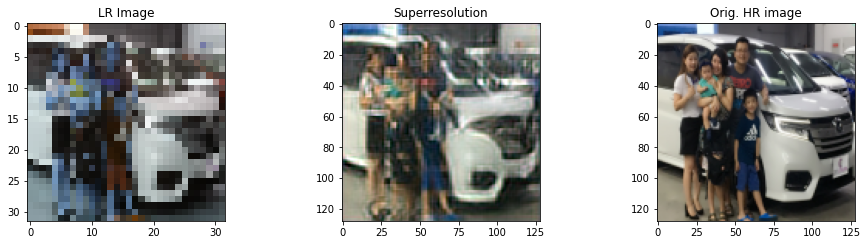

In [57]:
from keras.models import load_model
from numpy.random import randint

generator = load_model('/content/drive/MyDrive/Colab Notebooks/Nagasaki_summer_internship/models95.h5', compile=False)


[X1, X2] = [test_low_res,test_high_res]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

In [17]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(1,6):
    
    predicted = np.clip(model_1.predict(test_low_res[i].reshape(1,256, 256,3)),0.0,1.0).reshape(256, 256,3)
    plot_images(test_high_res[i],test_low_res[i],predicted)

NameError: ignored